In [1]:
from meteostat import Stations, Daily
from datetime import datetime
import seaborn as sns
import matplotlib.pyplot as plt

# Obtaining data

The first step is to choose the station in the state of Puebla, Mexico.

In [2]:
stations = Stations()
stations = stations.region('MX','PUE')
stations = stations.fetch(stations.count())

print(stations)

                           name country region    wmo  icao  latitude  \
id                                                                      
76685              Puebla, Pue.      MX    PUE  76685  MMPB   19.0500   
MMHC0  Tehuacan / Cinco Señores      MX    PUE   <NA>  MMHC   18.4971   

       longitude  elevation             timezone hourly_start hourly_end  \
id                                                                         
76685   -98.1667     2179.0  America/Mexico_City   1973-01-02 2024-10-08   
MMHC0   -97.4198     1679.0  America/Mexico_City   1973-01-01 1977-02-01   

      daily_start  daily_end monthly_start monthly_end  
id                                                      
76685  1975-04-04 2024-12-30    1988-01-01  2022-01-01  
MMHC0         NaT        NaT           NaT         NaT  


We conclude that Puebla, Pue. Station with WMO code 76685 is the station located at Puebla City, the study site. Now we analyze the coverage of the data to choose the appropiate period.

In [3]:
start = datetime(1974, 1, 1)
end = datetime(2024, 1, 1)

data = Daily('76685', start=start, end=end)
coverage_50_years = data.coverage()

start = datetime(1994, 1, 1)
end = datetime(2024, 1, 1)

data = Daily('76685', start = start, end = end)
coverage_30_years = data.coverage()

print('For 50 years the coverage is ' + '{:.2f}'.format(coverage_50_years * 100) 
      + '% and for 30 years is ' + '{:.2f}'.format(coverage_30_years * 100) + '%')

For 50 years the coverage is 74.18% and for 30 years is 99.98%


Since 30-years period has a suitable coverage in comparison to 50-years period, we normalize data. This step is esential for inteporlation and filling gaps.

In [4]:
start = datetime(1994, 1, 1)
end = datetime(2024, 1, 1)

data = Daily('76685', start=start, end=end)
data = data.normalize()
data = data.fetch()

data.head()

,tavg,tmin,tmax,prcp,snow,wdir,wspd,wpgt,pres,tsun
time,,,,,,,,,,
1994-01-01,14.3,5.0,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN
1994-01-02,16.0,5.0,24.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN
1994-01-03,14.1,0.0,21.4,0.0,NaN,NaN,NaN,NaN,NaN,NaN
1994-01-04,14.0,2.8,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN
1994-01-05,10.6,-1.6,23.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN


Now that the normalization is completed, we proceed to interpolate the data.

In [5]:
data = data.interpolate()
data.head()

,tavg,tmin,tmax,prcp,snow,wdir,wspd,wpgt,pres,tsun
time,,,,,,,,,,
1994-01-01,14.3,5.0,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN
1994-01-02,16.0,5.0,24.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN
1994-01-03,14.1,0.0,21.4,0.0,NaN,NaN,NaN,NaN,NaN,NaN
1994-01-04,14.0,2.8,22.2,0.0,NaN,NaN,NaN,NaN,NaN,NaN
1994-01-05,10.6,-1.6,23.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN


# Data processing

According to Camuffo, Becherini, & della Valle (2020), Return Periods (RP) are calculated with the next equation:
$$RP = \frac{365 \space \frac{days}{year} \times 100}{N_{year} \times (100 - SP)}$$
Where:

$RP$ Return Period (days)

$N_{year}$ Observations per year (365 $year^{-1}$ usually)

$SP$ Selected Percentile (%)

Isolating SP we get:

$$ SP = 100 - \frac{365 \space \frac{days}{year} \times 100}{N_{year} \times RP} $$

In this case, we have data for the entire year ($N_{year} = 365 \space year^{-1}$) and a 1-year return period ($RP = 365 \space \frac{days}{year} \times 1 \space year$) used for drainage systems design and agricultural planning. After substitution we find:

$$ SP=99.7260274 \% $$

In [6]:
sp = 100-(365*100)/(365*365*1)
sp = sp/100
sp

0.9972602739726026

## Precipitation

We assign the threshold value defined as an extreme event according the percentile calculated. 

In [7]:
prcp_threshold = data['prcp'].quantile(sp)
extreme_prcp = data['prcp'] > prcp_threshold
print('Number of days with extreme precipitation: ',extreme_prcp.sum())

Number of days with extreme precipitation:  13


After that we visualize the data

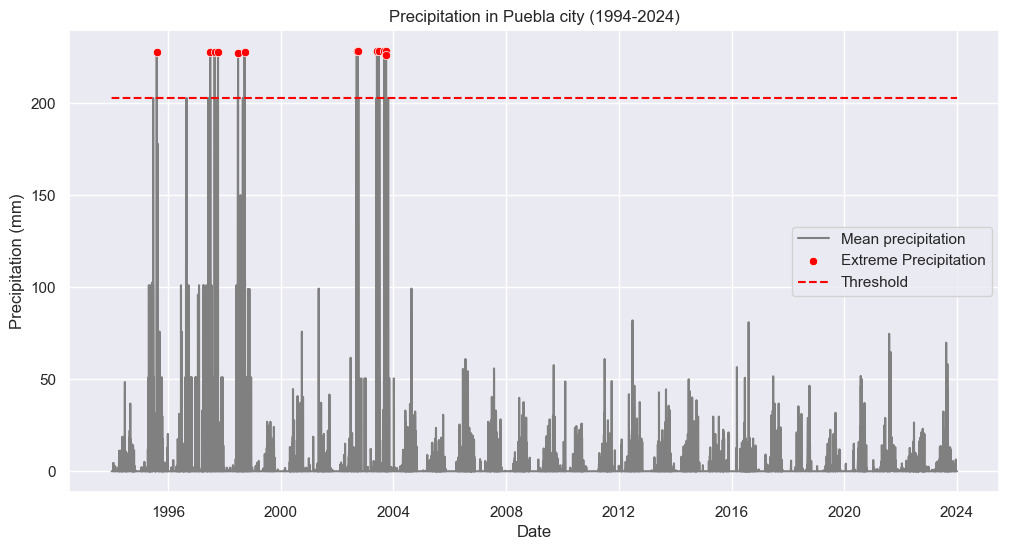

In [8]:
plt.figure(figsize=(12, 6))
sns.set_theme(style="darkgrid")

prcp = sns.lineplot(x=data.index, y=data['prcp'], color='gray', label='Mean precipitation', zorder=1)
sns.scatterplot(x=data.index[extreme_prcp], y=data['prcp'][extreme_prcp], color='red', label='Extreme Precipitation', zorder=2)
sns.lineplot(x=data.index, y=prcp_threshold, color='red', linestyle='--', label='Threshold', zorder=3)

prcp.set_title('Precipitation in Puebla city (1994-2024)')
prcp.set_xlabel('Date')
prcp.set_ylabel('Precipitation (mm)')

plt.savefig("prcp.png", dpi=300, bbox_inches='tight')

## Temperature

In [9]:
tmax_threshold = data['tmax'].quantile(sp)
extreme_tmax = data['tmax'] > tmax_threshold
print('Number of days with extreme maximum temperatures: ',extreme_tmax.sum())

tmin_threshold = data['tmin'].quantile(1-sp)
extreme_tmin = data['tmin'] < tmin_threshold
print('Number of days with extreme minimum temperatures: ',extreme_tmin.sum())

Number of days with extreme maximum temperatures:  31
Number of days with extreme minimum temperatures:  31


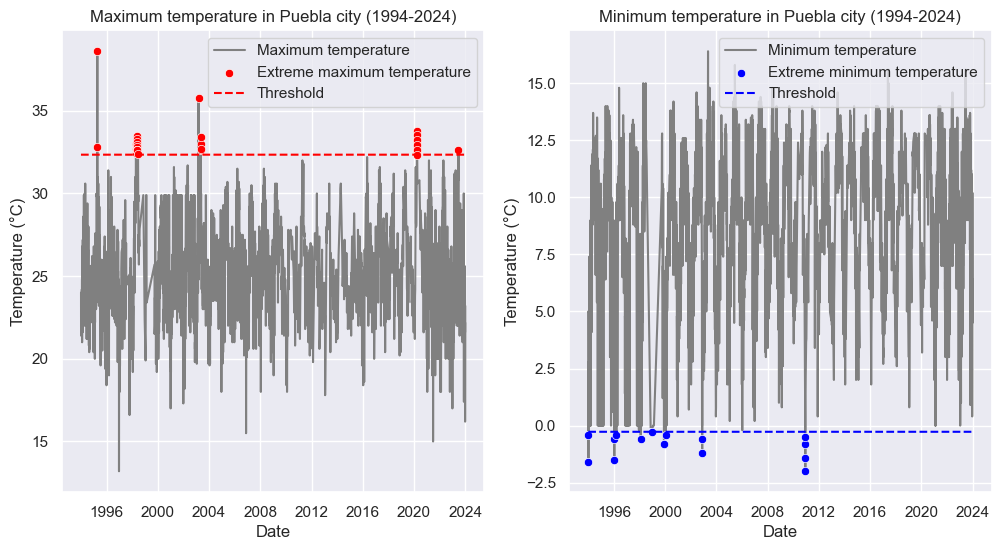

In [10]:
plt.figure(figsize=(12, 6))

plt.subplot(1,2,1)
tmax = sns.lineplot(x=data.index, y=data['tmax'], color='gray', label='Maximum temperature', zorder=1)
sns.scatterplot(x=data.index[extreme_tmax], y=data['tmax'][extreme_tmax], color='red', label='Extreme maximum temperature', zorder=2)
sns.lineplot(x=data.index, y=tmax_threshold, color='red', linestyle='--', label='Threshold', zorder=3)
tmax.set_title('Maximum temperature in Puebla city (1994-2024)')
tmax.set_xlabel('Date')
tmax.set_ylabel('Temperature (°C)')

plt.subplot(1,2,2)
tmin = sns.lineplot(x=data.index, y=data['tmin'], color='gray', label='Minimum temperature', zorder=1)
sns.scatterplot(x=data.index[extreme_tmin], y=data['tmin'][extreme_tmin], color='blue', label='Extreme minimum temperature', zorder=2)
sns.lineplot(x=data.index, y=tmin_threshold, color='blue', linestyle='--', label='Threshold', zorder=3)
tmin.set_title('Minimum temperature in Puebla city (1994-2024)')
tmin.set_xlabel('Date')
tmin.set_ylabel('Temperature (°C)')

plt.savefig("tmin_tmax.png", dpi=300, bbox_inches='tight')

In [11]:
tavgmax_threshold = data['tavg'].quantile(sp)
extreme_tavgmax = data['tavg'] > tavgmax_threshold

tavgmin_threshold = data['tavg'].quantile(1-sp)
extreme_tavgmin = data['tavg'] < tavgmin_threshold

print('Number of days with high extreme temperatures: ',extreme_tavgmax.sum())
print('Number of days with low extreme temperatures: ',extreme_tavgmin.sum())

Number of days with high extreme temperatures:  26
Number of days with low extreme temperatures:  27


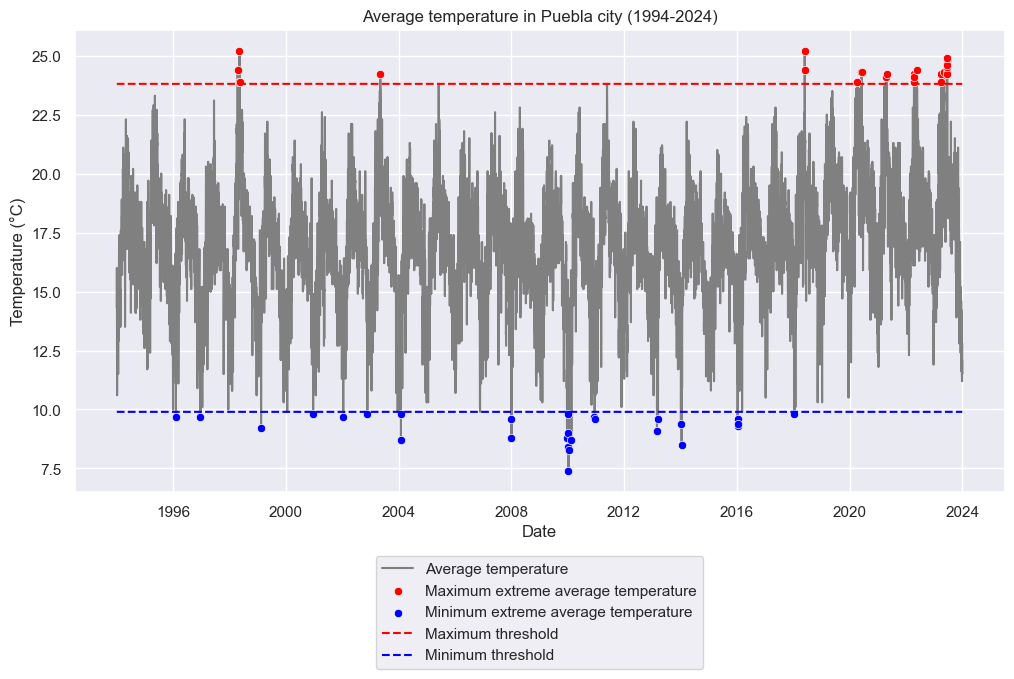

In [13]:
plt.figure(figsize=(12, 6))

tavg = sns.lineplot(x=data.index, y=data['tavg'], color='gray', label='Average temperature', zorder=1)
sns.scatterplot(x=data.index[extreme_tavgmax], y=data['tavg'][extreme_tavgmax], color='red', label='Maximum extreme average temperature', zorder=2)
sns.scatterplot(x=data.index[extreme_tavgmin], y=data['tavg'][extreme_tavgmin], color='blue', label='Minimum extreme average temperature', zorder=2)
sns.lineplot(x=data.index, y=tavgmax_threshold, color='red', linestyle='--', label='Maximum threshold', zorder=3)
sns.lineplot(x=data.index, y=tavgmin_threshold, color='blue', linestyle='--', label='Minimum threshold', zorder=3)
tavg.set_title('Average temperature in Puebla city (1994-2024)')
tavg.set_xlabel('Date')
tavg.set_ylabel('Temperature (°C)')
tavg.legend(loc='lower center', bbox_to_anchor=(0.5, -0.4))

plt.savefig("tavg.png", dpi=300, bbox_inches='tight')

# References

Camuffo, D., Becherini, F., & della Valle, A. (2020). Relationship between selected percentiles and return periods of extreme events. *Acta Geophysica, 68*(4), 1201–1211. https://doi.org/10.1007/s11600-020-00452-x